In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import make_pipeline
from scipy import stats
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
#load data
df_train = pd.read_csv('Documents/KaggleProjects/house_prices/train.csv')
df_test = pd.read_csv('Documents/KaggleProjects/house_prices/test.csv')

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
print("df_train : " + str(df_train.shape))

df_train : (1460, 81)


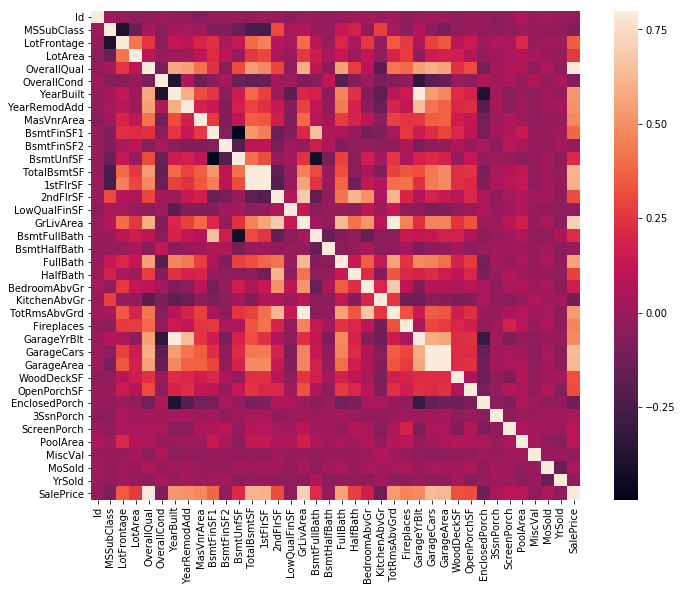

In [7]:
#correlation matrix
corr_mat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

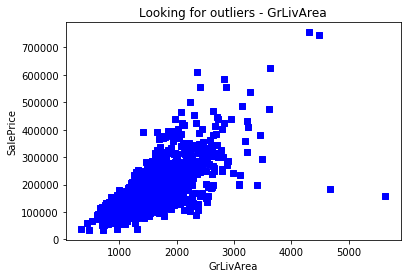

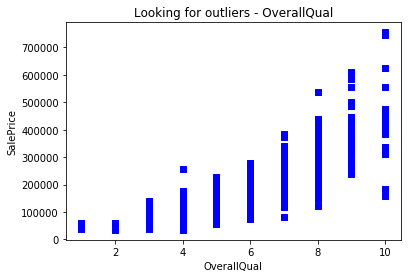

In [8]:
#look for outliers of GrLivArea and OverallQual (best correlation)

plt.scatter(df_train.GrLivArea, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers - GrLivArea")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

plt.scatter(df_train.OverallQual, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers - OverallQual")
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
plt.show()

In [9]:
#delete outliers - big house, low price

df_train.nlargest(4,'GrLivArea')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


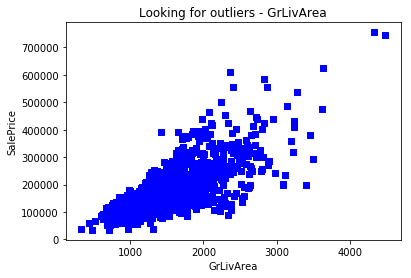

In [10]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers - GrLivArea")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [11]:
#Log transform to saleprice
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [12]:
#check for NA

for col in df_train.columns:
    if df_train[col].isnull().any():
        print (col)

#print('MSSubClass')
#df_train['MSSubClass'].isnull().any()

#print('MSZoning')
#df_train['MSZoning'].isnull().any()





LotFrontage
Alley
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


In [13]:
##Handle missing values

#LotFrontage: assume NA means no frontage
df_train.loc[:,'LotFrontage'] = df_train.loc[:,'LotFrontage'].fillna(0)

#Alley NA means no alley access
df_train.loc[:,'Alley'] = df_train.loc[:,'Alley'].fillna('NONE')

#MasVnrType NA means no Masonry veneer
df_train.loc[:,'MasVnrType'] = df_train.loc[:,'MasVnrType'].fillna('NONE')

#MasVnrArea NA means Masonry veneer area = 0 
df_train.loc[:,'MasVnrArea'] = df_train.loc[:,'MasVnrArea'].fillna(0)

#BsmtQual NA means No Basement
df_train.loc[:,'BsmtQual'] = df_train.loc[:,'BsmtQual'].fillna('NONE')

#BsmtCond NA means No Basement
df_train.loc[:,'BsmtCond'] = df_train.loc[:,'BsmtCond'].fillna('NONE')

#BsmtExposure NA means No Basement
df_train.loc[:,'BsmtExposure'] = df_train.loc[:,'BsmtExposure'].fillna('NONE')

#BsmtFinType1 NA means No Basement
df_train.loc[:,'BsmtFinType1'] = df_train.loc[:,'BsmtFinType1'].fillna('NONE')

#BsmtFinType2 NA means No Basement
df_train.loc[:,'BsmtFinType2'] = df_train.loc[:,'BsmtFinType2'].fillna('NONE')

#Electrical NA only appear once, delete this index
df_train.loc[:,'Electrical'] = df_train.loc[:,'Electrical'].dropna()

#FireplaceQu NA means No Fireplace
df_train.loc[:,'FireplaceQu'] = df_train.loc[:,'FireplaceQu'].fillna('NONE')

#GarageType NA means No garage
df_train.loc[:,'GarageType'] = df_train.loc[:,'GarageType'].fillna('NONE')

#GarageYrBlt NA means No garage
df_train.loc[:,'GarageYrBlt'] = df_train.loc[:,'GarageYrBlt'].fillna('NONE')

#GarageFinish NA means No garage
df_train.loc[:,'GarageFinish'] = df_train.loc[:,'GarageFinish'].fillna('NONE')

#GarageQual NA means No garage
df_train.loc[:,'GarageQual'] = df_train.loc[:,'GarageQual'].fillna('NONE')

#GarageCond NA means No garage
df_train.loc[:,'GarageCond'] = df_train.loc[:,'GarageCond'].fillna('NONE')

#PoolQC NA means No pool
df_train.loc[:,'PoolQC'] = df_train.loc[:,'PoolQC'].fillna('NONE')

#Fence NA means No Fence
df_train.loc[:,'Fence'] = df_train.loc[:,'Fence'].fillna('NONE')

#MiscFeature NA means None
df_train.loc[:,'MiscFeature'] = df_train.loc[:,'MiscFeature'].fillna('NONE')

In [14]:
# Integers that should be categories

df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
df_train['OverallQual'] = df_train['OverallQual'].astype(str)
df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)


In [15]:
# Categorical features when order of categories is important

features = ('Street', 'Alley', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence')

for ft in features:
    lbl = LabelEncoder() 
    lbl.fit(list(df_train[ft].values)) 
    df_train[ft] = lbl.transform(list(df_train[ft].values))
    

In [16]:
# Most important features
print("Most important features")
corr = df_train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Most important features
SalePrice        1.000000
GrLivArea        0.725211
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
OverallQual      0.623915
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
Fireplaces       0.491998
MasVnrArea       0.430569
BsmtFinSF1       0.392283
WoodDeckSF       0.334250
OpenPorchSF      0.325215
GarageCond       0.323688
2ndFlrSF         0.319953
HalfBath         0.314186
PavedDrive       0.304683
GarageQual       0.275685
LotArea          0.260544
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
LotFrontage      0.183181
ExterCond        0.148540
Fence            0.139429
Functional       0.131350
BsmtCond         0.122430
ScreenPorch      0.121245
Alley            0.112835
PoolArea         0.074338
BsmtFinType2     0.072401
Street           0.057364
3SsnPorch        0.054914
LandSlope        0.038552
BsmtFinSF2    

In [17]:
# find and fix skewed data

y_train = df_train['SalePrice']
train_num_features = df_train.select_dtypes(exclude = ["object"]).columns
train_num_features = train_num_features.drop('SalePrice')
train_num_data = df_train[train_num_features]
train_num_data = train_num_data.fillna(train_num_data.median())
skewness = train_num_data.apply(lambda x: stats.skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
train_num_data[skewed_features] = np.log1p(train_num_data[skewed_features])

for ft in skewed_features:
    df_train[ft] = train_num_data[ft]

print (df_train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [18]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,9.042040,0.693147,1,Reg,Lvl,0.0,...,0.0,1.386294,1.609438,NONE,0.0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9.169623,0.693147,1,Reg,Lvl,0.0,...,0.0,1.386294,1.609438,NONE,0.0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,9.328212,0.693147,1,IR1,Lvl,0.0,...,0.0,1.386294,1.609438,NONE,0.0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9.164401,0.693147,1,IR1,Lvl,0.0,...,0.0,1.386294,1.609438,NONE,0.0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,9.565284,0.693147,1,IR1,Lvl,0.0,...,0.0,1.386294,1.609438,NONE,0.0,12,2008,WD,Normal,12.429216


In [19]:
# Save and drop id column - irelevant to analysis
train_ID = df_train['Id']
test_ID = df_test['Id']
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [20]:
# split data to train and validation data

df_train = pd.get_dummies(df_train)
y_train = df_train['SalePrice']
df_train.drop('SalePrice', axis=1, inplace=True)
X_train,X_val,Y_train,Y_val = train_test_split(df_train,y_train,test_size = 0.2,random_state= 0)

In [21]:
print("X_train : " + str(X_train.shape))
print("X_val : " + str(X_val.shape))
print("y_train : " + str(Y_train.shape))
print("y_val : " + str(Y_val.shape))

X_train : (1166, 351)
X_val : (292, 351)
y_train : (1166,)
y_val : (292,)


In [22]:
# define error measure: rmse

scorer = make_scorer(mean_squared_error,greater_is_better = False)
n_folds = 5

def rmse_cv_train(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(df_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train, Y_train, scoring = scorer, cv = kf))
    return rmse

def rmse_cv_val(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(df_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_val, Y_val, scoring = scorer, cv = kf))
    return rmse

RMSE on Training set : 0.15068815490941684
RMSE on Test set : 0.877137031782578


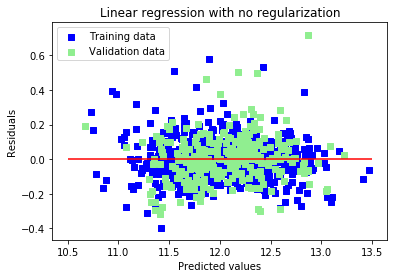

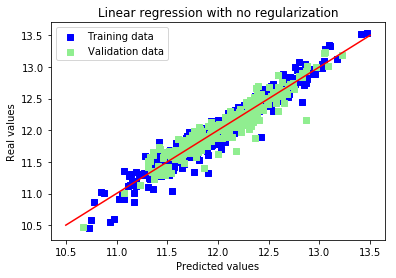

Linear picked 350 features and eliminated the other 1 features


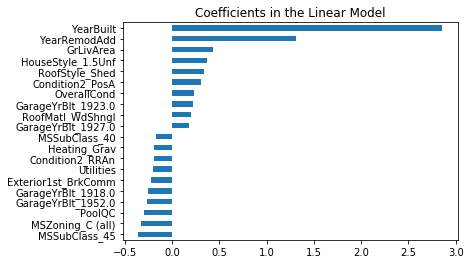

In [21]:
# linear reggression
linearReg = LinearRegression()
linearReg.fit(X_train, Y_train)
print("RMSE on Training set :", rmse_cv_train(linearReg).mean())
print("RMSE on Test set :", rmse_cv_val(linearReg).mean())

Y_train_rdg = linearReg.predict(X_train)
Y_val_rdg = linearReg.predict(X_val)

# Plot residuals
plt.scatter(Y_train_rdg, Y_train_rdg - Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_rdg, Y_val_rdg - Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with no regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(Y_train_rdg, Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_rdg, Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with no regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(linearReg.coef_, index = X_train.columns)
print("Linear picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")
plt.show()

In [31]:
# fit to ridgeCV regression

#first fit
first_alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
ridge_cv = RidgeCV(alphas = first_alphas)
ridge_cv.fit(X_train, Y_train)
alpha = ridge_cv.alpha_
print('Temp best alpha:' + str(alpha))

#second fit for more precision
second_alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4]
ridge_cv = RidgeCV(alphas = second_alphas)
ridge_cv.fit(X_train, Y_train)
alpha = ridge_cv.alpha_

print('Best alpha: ' + str(alpha))



Temp best alpha:10.0
Best alpha: 8.0


Ridge RMSE on Training set : 0.12561207522241435
Ridge RMSE on Test set : 0.14517823100947497


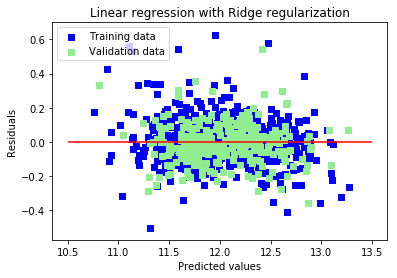

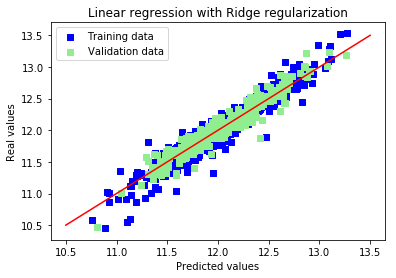

Ridge picked 347 features and eliminated the other 4 features


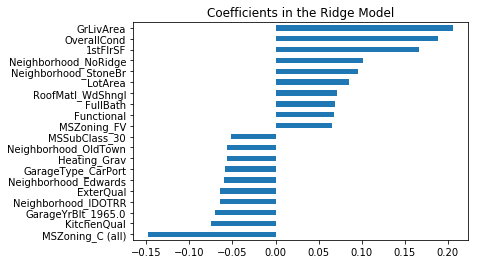

In [32]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge_cv).mean())
print("Ridge RMSE on Test set :", rmse_cv_val(ridge_cv).mean())
Y_train_rdg = ridge_cv.predict(X_train)
Y_val_rdg = ridge_cv.predict(X_val)

# Plot residuals
plt.scatter(Y_train_rdg, Y_train_rdg - Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_rdg, Y_val_rdg - Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(Y_train_rdg, Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_rdg, Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge_cv.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Temp best alpha:0.01
Best alpha: 0.006
Lasso RMSE on Training set : 0.15386872181238637
Lasso RMSE on Test set : 0.1505409012752012


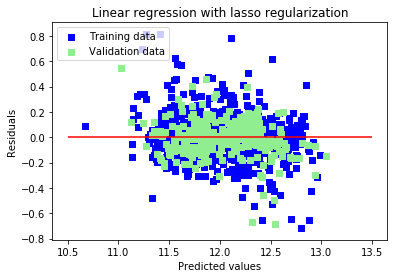

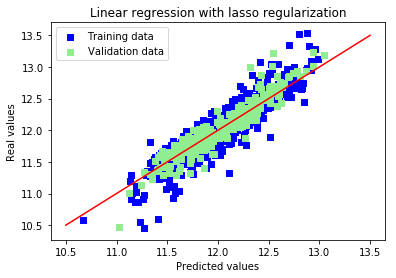

Lasso picked 38 features and eliminated the other 313 features


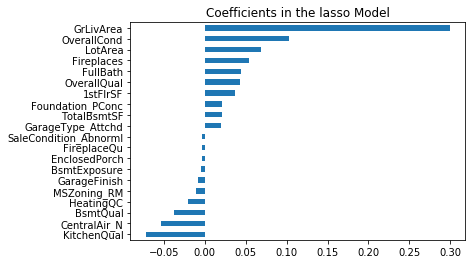

In [24]:
# fit to LassoCV regression

#first fit
first_alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
lasso_cv = LassoCV(alphas = first_alphas)
lasso_cv.fit(X_train, Y_train)
alpha = lasso_cv.alpha_
print('Temp best alpha:' + str(alpha))

#second fit for more precision
second_alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4]
lasso_cv = LassoCV(alphas = second_alphas)
lasso_cv.fit(X_train, Y_train)
alpha = lasso_cv.alpha_

print('Best alpha: ' + str(alpha))

print("Lasso RMSE on Training set :", rmse_cv_train(lasso_cv).mean())
print("Lasso RMSE on Test set :", rmse_cv_val(lasso_cv).mean())
Y_train_rdg = lasso_cv.predict(X_train)
Y_val_rdg = lasso_cv.predict(X_val)

# Plot residuals
plt.scatter(Y_train_rdg, Y_train_rdg - Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_rdg, Y_val_rdg - Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(Y_train_rdg, Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_rdg, Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso_cv.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the lasso Model")
plt.show()

Tried different first alphas, no change in RMSE due to the second round

Lasso RMSE on Training set : 0.12391109935385872
Lasso RMSE on Test set : 0.13690912355801033


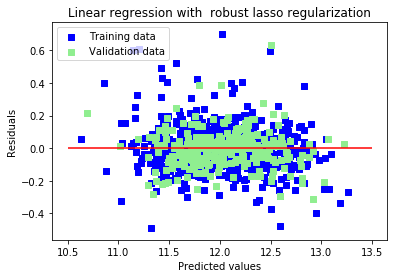

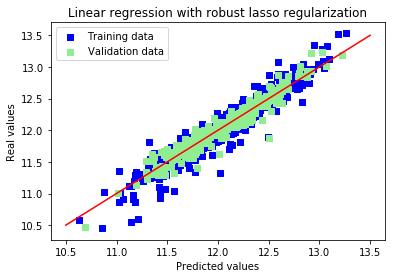

In [46]:
# Lasso is sensitive to outliers, lets try with RobustScaler()

lasso_robust = make_pipeline(RobustScaler(), Lasso(alpha =0.0008, random_state=1))
lasso_robust.fit(X_train, Y_train)


print("Lasso RMSE on Training set :", rmse_cv_train(lasso_robust).mean())
print("Lasso RMSE on Test set :", rmse_cv_val(lasso_robust).mean())

Y_train_robust = lasso_robust.predict(X_train)
Y_val_robust = lasso_robust.predict(X_val)

# Plot residuals
plt.scatter(Y_train_robust, Y_train_robust - Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_robust, Y_val_robust - Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with  robust lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(Y_train_robust, Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_robust, Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with robust lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


Tried different alpha hyper parameter:

alpha = 0.0005
Lasso RMSE on Training set : 0.12296735613622194
Lasso RMSE on Test set : 0.14221568753992359

alpha = 0.005
Lasso RMSE on Training set : 0.1357309239531738
Lasso RMSE on Test set : 0.13350041620093572

alpha = 0.05
Lasso RMSE on Training set : 0.19345183730866478
Lasso RMSE on Test set : 0.18224952005449385


alpha = 0.0008
Lasso RMSE on Training set : 0.12391109935385872
Lasso RMSE on Test set : 0.13690912355801033

alpha = 0.001
Lasso RMSE on Training set : 0.12485143706970862
Lasso RMSE on Test set : 0.13568697092540563

alpha = 0.0009
Lasso RMSE on Training set : 0.12434629747567297
Lasso RMSE on Test set : 0.13627187412573155

alpha = 0.0007
Lasso RMSE on Training set : 0.12358591701761609
Lasso RMSE on Test set : 0.13777455981809436

chosen alpha = 0.0008

In [53]:
#XGBoost

xgboost_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


In [54]:

xgboost_model.fit(X_train, Y_train)


print("XGBoost RMSE on Training set :", rmse_cv_train(xgboost_model).mean())
print("XGBoost RMSE on Test set :", rmse_cv_val(xgboost_model).mean())



XGBoost RMSE on Training set : 0.1276498189513035
XGBoost RMSE on Test set : 0.14180135554984466


Different hyperparameters:

*colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=2200,
    reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state =7, nthread = -1

    XGBoost RMSE on Training set : 0.1265188258511771
    XGBoost RMSE on Test set : 0.14152530222270282

*colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.5, max_depth=3, min_child_weight=1.7817, n_estimators=2200,
    reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state =7, nthread = -1

    XGBoost RMSE on Training set : 0.1587696722669188
    XGBoost RMSE on Test set : 0.18490736758652962
    
*colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.005, max_depth=3, min_child_weight=1.7817, n_estimators=2200,
    reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state =7, nthread = -1 

    XGBoost RMSE on Training set : 0.12933800344882126
    XGBoost RMSE on Test set : 0.14380943844457492
    
*colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=5, min_child_weight=1.7817, n_estimators=2200,
    reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state =7, nthread = -1
    
    XGBoost RMSE on Training set : 0.12738683217737595
    XGBoost RMSE on Test set : 0.1421571925894693
    
*colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=7, min_child_weight=1.7817, n_estimators=2200,
    reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state =7, nthread = -1
    
    XGBoost RMSE on Training set : 0.1276498189513035
    XGBoost RMSE on Test set : 0.14180135554984466
    
 chose first option

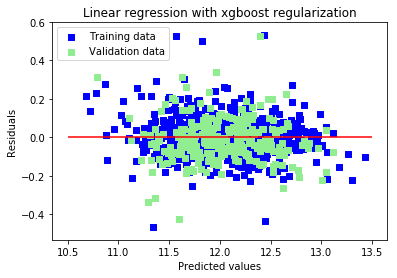

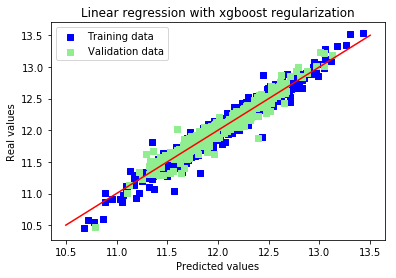

In [27]:

Y_train_xgb = xgboost_model.predict(X_train)
Y_val_xgb = xgboost_model.predict(X_val)

# Plot residuals
plt.scatter(Y_train_xgb, Y_train_xgb - Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_xgb, Y_val_xgb - Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with xgboost regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(Y_train_xgb, Y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(Y_val_xgb, Y_val, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with xgboost regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

The best option is Lasso with robust scalar